In [1]:
#載入所需函示庫
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 100
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import math
import statistics
from statsmodels.tsa.api import Holt
from stepwise_regression import step_reg
import time
import itertools

In [2]:
def my_inference(p_value, alpha, claim):
    if p_value < alpha:
        print(f"Since the p_value = {p_value:.4f} < {alpha}, we reject the null hypothesis.\nThat is, we have sufficient evidence to claim that {claim}.")
    else:
        print(f"Since the p_value = {p_value:.4f} > {alpha}, we do not reject the null hypothesis.\nThat is, we do not have sufficient evidence to claim that {claim}.")

def my_normality_check(sample_data, data_name, data_unit, alpha):
    # histogram
    fig, ax = plt.subplots()
    counts, bins, patches = plt.hist((sample_data.dropna()).astype(float), 6, density=False, facecolor='g', alpha=0.75)
    plt.title(f'Histogram of {data_name}')
    plt.xlabel(data_unit)
    plt.ylabel('Frequency')
    plt.grid(True)
    
    # Shapiro-Wilk test
    print("Shapiro-Wilk test for normality:")
    print("H0: The distribution is normal.")
    print("H1: The distribution is not normal.")
    stat, p = stats.shapiro(sample_data.dropna())
    print(f'For population = {data_name}')
    print(f"Shapiro statistic = {stat:.6f} and p_value = {p:.6f}")
    p_value = p; claim = "the distribution is not normal"
    my_inference(p_value, alpha, claim)
    
    # QQ plot
    fig = sm.qqplot(sample_data.dropna(), stats.norm, fit=True, line='45')
    plt.title(f'Q-Q Plot for {data_name}')
    plt.show()

def my_scatter_plot(sample_data, X_name, Y_name, X_unit, Y_unit):
    _ = sns.regplot(x = sample_data[X_name], y = sample_data[Y_name], color = 'b', ci = None)
    plt.title(f'Scatter Plot for {X_name} and {Y_name}')
    plt.xlabel(f'{X_name} ({X_unit})')
    plt.ylabel(f'{Y_name} ({Y_unit})')
    plt.show()
    
def Sample_Mean_Hypothesis_Testing(x, H0_x_bar, a):
    a = 0.05
    x_bar = x.mean()
    x_std = x.std()
    x_n = x.size
    print(f"mean = {x_bar:.4f}")
    print(f"std. dev. = {x_std:.4f}")
    print(f"Number of observation = {x_n}")
    print(f"Hypothesized mean = {H0_x_bar}")
    print(f"Significant level = {a}")
    tstat = (x_bar - H0_x_bar) / (x_std / (x_n ** 0.5))
    print(f"t-stat = {tstat:.4f}")
    if tstat > 0:
        tcv_onetail = stats.t.ppf(1 - a, df = x_n - 1)
    else:
        tcv_onetail = stats.t.ppf(a, df = x_n - 1)    
    print(f"t critical value one tail = {tcv_onetail:.4f}")
    if tstat > 0:
        p_onetail = 1 - stats.t.cdf(tstat, df = x_n - 1)
    else:
        p_onetail = stats.t.cdf(tstat, df = x_n - 1)
    print(f"p-value (one-tail) = {p_onetail:.4f}")
    if tstat > 0:
        tcv_twotail = stats.t.ppf(1 - a/2, df = x_n - 1)
    else:
        tcv_twotail = stats.t.ppf(a/2, df = x_n - 1)
    print(f"t critical value two tail = {tcv_twotail:.4f}")
    p_twotail = p_onetail * 2
    print(f"p-value (two-tail) = {p_twotail:.4f}")
    return p_onetail, p_twotail

def runsTest(l, l_median): 
    runs, n1, n2 = 1, 0, 0
    if(l[0]) >= l_median:
        n1 += 1   
    else:
        n2 += 1   
    for i in range(1, len(l)): 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
        if(l[i]) >= l_median: 
            n1 += 1   
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    print('runs_exp = ', runs_exp)
    print('stan_dev = ', stan_dev)
    print('z = ', z)
    print('pval_z = ', pval_z)
    return pval_z

def Durbin_Watson_test(x):
    x_square_sum = np.vdot(x, x)
    print("x_square_sum = ", x_square_sum)
    size = x.size
    print("size = ", size)
    x_d = np.zeros((size))
    print("x_d = ", x_d)
    l_size = size - 1
    for i in range(l_size):
        x_d[i + 1] = x[i + 1] - x[i]
    print("x_d = ", x_d)
    d = np.vdot(x_d, x_d) / x_square_sum
    print("d = ", d)
    return(d)

def required_conditions_for_error(SD, y_pre, Y_name):
    # check required conditions
    print('Checking for required conditions for error variable:\n')

    mu = np.mean(SD)
    sigma = np.std(SD)
    
    ## The error is a random variable with mean of zero.
    print('\n1. Zero mean')
    print(f'H0: Errors have zero mean.')
    print(f'H1: Errors do not have zero mean.')
    H0_x_bar = 0
    p_onetail, p_twotail = Sample_Mean_Hypothesis_Testing(SD, H0_x_bar, 0.05)
    claim = "the errors do not have zero mean"
    my_inference(p_twotail, 0.05, claim)
    
    print(f'\n2. Normality')
    print(f'H0: Errors are normally distributed.')
    print(f'H1: Errors are not normally distributed.')
    
    
    ## The error is a normally distributed random variable.
    my_normality_check(pd.Series(SD), "standarized residuals", "unit", 0.05)
    
    ## The variance of the error term is the same for all values of the independent variable.
    print('\n3. Homoskedasticity')
    print('H0: Homoskedasticity')
    print('H1: Heteroskedasticity')
    
    plt.plot(y_pre, SD, 'o', color = 'gray')
    plt.axhline(y=0, color = 'blue')
    plt.axhline(y=2, color = 'red')
    plt.axhline(y=-2, color = 'red')
    plt.title('Standardized Residual Plot')
    plt.xlabel(Y_name)
    plt.ylabel('Standardized Residual')
    plt.show()
    print('Do not rejected H0. Heteroscedasticity does not appear to be a problem.')
    
    
    ## The values of the error are independent
    print('\n4. Independence')
    print('\n4-1. Randomness')
    print('H0 : Randomness exists.')
    print('H1 : Randomness does not exist.')
    SD_median = statistics.median(SD)
    Z_pval = runsTest(SD, SD_median)
    print('p_value for Z-statistic= ', Z_pval)
    claim = 'randomness does not exist'
    my_inference(Z_pval, 0.05, claim)
    
    print('\n4-2. No Autocorrelation')
    print('H0 : There is no first-order correlation.')
    print('H1 : There is first-order correlation.')
    
#     d = Durbin_Watson_test(x)
    
def my_multicollinearity_test(y, X):
    data = pd.concat([y, X], axis=1)
    corr = data.corr()
    _ = sns.heatmap(corr, annot=True)
    multicollinearity_pairs = []
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if (corr.iloc[i, j] > 0.7):
                multicollinearity_pairs.append((corr.columns[i], corr.columns[j]))
    if len(multicollinearity_pairs) == 0:
        print("Multicollinearity will not be a problem.")
    else:
        print(f"Multicollinearity exists between {multicollinearity_pairs}.")
    return multicollinearity_pairs

def my_outlier(SD):
    df = pd.DataFrame(SD,columns = ['SD'])
    filter = (df['SD'] < -2) | (df['SD'] > 2)
    outliers = df['SD'].loc[filter]
    if len(outliers) == 0:
        print('There are no outliers.')
    else:
        print("Outliers by SD = \n")
        print(outliers)
        print('\nOutliers:')
        out = ''
        indices = outliers.index
        for i, idx in enumerate(indices):
            if i == len(indices) - 1:
                out += f'sample {idx + 1}.'
            else:
                out += f'sample {idx + 1}, '
        print(out)
        
def my_hii(X, ols_result):
    H = np.matmul(X, np.linalg.solve(np.matmul(X.T, X), X.T))
    df_h = pd.DataFrame({
        'hii': np.diagonal(H)
    })
    k = ols_result.df_model
    n = len(df_h['hii'])
    h_level = 3 * (k + 1) / n 
    print("h_level = ", h_level)
    print(" \n")
    filter = (df_h['hii'] > h_level )
    hii = df_h['hii']
    inf_hii = hii.loc[filter]
    if len(inf_hii) == 0:
        print('There are no influential observations by hii.')
    else:
        print("Influential observations by hii = \n")
        print(inf_hii)
        print('\Influential observations:')
        out = ''
        indices = inf_hii.index
        for i, idx in enumerate(indices):
            if i == len(indices) - 1:
                out += f'sample {idx + 1}.'
            else:
                out += f'sample {idx + 1}, '
    return hii, inf_hii
    

def my_cooks_distance(ols_result, data, hii):
    s2_e = ols_result.mse_resid
    k = ols_result.df_model
    y_a = data[:, 1]
    y_f = data[:, 2]
    CD_arr = np.square(y_a - y_f) / s2_e / (k - 1) * hii / np.square(1 - hii)
    CD = np.array(CD_arr)
    df_cd = pd.DataFrame(CD,columns = ['CD'])
    filter = (df_cd['CD'] > 1 )
    inf_cd = df_cd['CD'].loc[filter]
    
    if len(inf_cd) == 0:
        print("There are no influential observations by Cook's Distances.")
    else:
        print("Influential observations by Cook's Distances = \n")
        print(inf_cd)
        print('\Influential observations:')
        out = ''
        indices = inf_cd.index
        for i, idx in enumerate(indices):
            if i == len(indices) - 1:
                out += f'sample {idx + 1}.'
            else:
                out += f'sample {idx + 1}, '
    return inf_cd

def my_simple_linear_regression(sample_data, X_name, Y_name, X_unit, Y_unit, alpha):
    # scatter plot
    my_scatter_plot(sample_data, X_name, Y_name, X_unit, Y_unit)
    
    # ols regression
    ols_result = smf.ols(f'{Y_name} ~ {X_name}', data = sample_data).fit()  
    display(ols_result.summary())
    b1 = ols_result.params[1]
    b0 = ols_result.params[0]
    print(f"Estimated model: {Y_name} = {b0:0.4f} + {b1:0.4f} {X_name}")
    
    ## interpret the model
    print(f'The intercept is b0 = {b0:0.4f}.')
    print(f'The slope of the line is b1 = {b1:0.4f}. For each additional {X_unit} on {X_name}, \
          {Y_name} decreases by an average of {b1:0.4f} {Y_unit}.')
    

    
    # check required conditions
    
    ## required conditions for error term
    st, data, ss = sso.summary_table(ols_result, alpha = alpha)
    SD = data[:, 10]
    y_pre = data[:, 2]
    
    required_conditions_for_error(SD, y_pre, Y_name)
    
    # detecting outliers
    my_outlier(SD)
    
    # influential observations
    ## hii
    hii, inf_hii = my_hii(sample_data.drop(sample_data.columns[0], axis = 1) , ols_result)
    
    ## cook's distance
    my_cooks_distance(ols_result, data, hii)
    
    # assessing the model
    print('Assessing the model:')
    ## standard error of estimate
    print('Assessment 1: standard error of estimate')
    s2_e = ols_result.mse_resid
    print(f'MSE: {s2_e:.4f}')
    s_e = ols_result.mse_resid ** 0.5
    print(f'Standard errors: {s_e:.4f}')
    print(f"mean of y = {sample_data[Y_name].mean():.4f}")
    print(f"variance of y = {sample_data[Y_name].var(ddof=1):.4f}")
    print(f"standard deviation of y = {sample_data[Y_name].std(ddof=1):.4f}")


    ## using descriptive measurements, r2 and r
    print('Assessment 2: using descriptive measurements, r2 and r')
    r, pvalue = stats.pearsonr(sample_data[Y_name], sample_data[X_name])
    print("r = ", r)
    print("r^2 = ", r**2)
     
    
    ## testing and/or estimating the coefficients
    print('Assessment 3: testing and/or estimating the coefficients')

def my_multiple_linear_regression(y, X, alpha):
    Y_name = y.name
    
    ## no muliticollinearity
    multicollinearity_pairs = my_multicollinearity_test(y, X)
    
    # ols regression
#     regression_str = Y_name + " ~ "
#     for idx, x_name in enumerate(X.columns):
#         if idx == 0:
#             regression_str += x_name
#         else:
#             regression_str += f" + {x_name}"
#     print(regression_str)
    X = sm.add_constant(X)

    # olsmod = sm.OLS(Y, sm.add_constant(X))
    # result_reg_1a = olsmod.fit()
    # print(result_reg_1a.summary())
    
    ols_result = sm.OLS(y, X).fit()
    print(ols_result.summary())
    
    # check required conditions
    
    ## required conditions for error term
    st, data, ss = sso.summary_table(ols_result, alpha = alpha)
    SD = data[:, 10]
    y_pre = data[:, 2]
    required_conditions_for_error(SD, y_pre, y.name)
    
    # detecting outliers
    my_outlier(SD)
    
    # influential observations
    ## hii
    hii, inf_hii = my_hii(X, ols_result)
    
    ## cook's distance
    my_cooks_distance(ols_result, data, hii)
    
    
    print('\nAssessing the model:')
    
    ## The Standard Error of Estimate 
    print('\nAssessment 1: standard error of estimate')
    s2_e = ols_result.mse_resid
    print(f'MSE: {s2_e:.4f}')
    s_e = ols_result.mse_resid ** 0.5
    print(f'Standard errors: {s_e:.4f}')
    print(f"mean of y = {y.mean():.4f}")
    print(f"variance of y = {y.var(ddof=1):.4f}")
    print(f"standard deviation of y = {y.std(ddof=1):.4f}")
    
    ## The Coefficient of Determination
    print('\nAssessment 2: Coefficient of Determination')
    print(f"R-squared: {ols_result.rsquared}")
    print(f"Adjusted R-squared: {ols_result.rsquared_adj}")
    if abs(ols_result.rsquared - ols_result.rsquared_adj) > 0.06:
        print(f'Since the difference between R-squared and the adjusted R-squared is {abs(ols_result.rsquared - ols_result.rsquared_adj):.4f} > 0.06, there might be a problem of over-fitting.')
    else:
        print(f'Since the difference between R-squared and the adjusted R-squared is {abs(ols_result.rsquared - ols_result.rsquared_adj):.4f} <= 0.06, there will not be a problem of over-fitting.')
    
    ## The F-test of ANOVA
    f_res = ols_result.fvalue
    print("F value = ", f_res)
    MSE = ols_result.mse_resid
    df_model = ols_result.df_model
    df_error = ols_result.df_resid
    MSR = f_res * MSE
    SSR = MSR * df_model
    print("SSR = ", SSR, "df = ", df_model, "MSR = ", MSR)
    print("SSE = ", MSE * df_error, "df = ", df_error, "MSE = ", MSE)
    print("F = ", MSR / MSE)
    A = np.identity(len(ols_result.params))
    A = A[1:,:]
    print("F test = ", ols_result.f_test(A))
    p_value = ols_result.f_pvalue
    claim = 'the model is valid'
    my_inference(p_value, alpha, claim)
    return ols_result
    
    ## Testing of the Coefficients
#     print('\nAssessment 3: testing and/or estimating the coefficients')

In [3]:
#讀取資料集
df = pd.read_csv('nba_stats_v3.csv')
print('Head of dataset:')
display(df.head())
print("Tail of dataset:")
display(df.tail())

Head of dataset:


,Age,G,GS,MP,3P%,STL,PF,Level1,Level2,PosCtg,...,log3P,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,logTOV,logPTS
0,20,18,0,3.7,0.280,0.1,0.2,1,0,F,...,0.336472,0.182322,0.262364,0.095310,0.182322,0.262364,0.336472,0.262364,0.182322,0.955511
1,22,17,8,21.6,0.375,0.4,1.4,0,1,F,...,0.530628,0.875469,1.193922,0.693147,0.916291,1.252763,1.504077,0.641854,0.405465,1.931521
2,23,40,0,14.2,0.308,0.7,1.5,0,0,G,...,0.470004,1.064711,1.410987,0.587787,0.641854,0.788457,0.916291,1.435085,0.832909,1.987874
3,28,75,74,33.5,0.461,0.9,2.1,0,1,G,...,1.308333,1.029619,1.435085,0.993252,1.098612,1.458615,1.589235,1.386294,0.832909,2.674149
4,31,60,3,16.9,0.366,0.4,2.1,1,0,C,...,0.336472,1.163151,1.547563,0.470004,0.587787,1.308333,1.629241,0.693147,0.530628,1.987874


Tail of dataset:


,Age,G,GS,MP,3P%,STL,PF,Level1,Level2,PosCtg,...,log3P,log2P,log2PA,logFT,logFTA,logDRB,logTRB,logAST,logTOV,logPTS
461,24,31,11,18.1,0.330,0.4,1.6,0,1,F,...,0.693147,1.029619,1.386294,0.470004,0.530628,1.029619,1.223775,0.530628,0.530628,2.104134
462,23,60,2,12.4,0.286,0.4,1.7,1,0,F,...,0.095310,0.916291,1.280934,0.336472,0.530628,0.916291,1.163151,0.641854,0.405465,1.547563
463,26,28,1,13.9,0.451,0.2,1.1,0,0,F,...,0.916291,0.262364,0.587787,0.405465,0.405465,0.788457,0.875469,0.470004,0.530628,1.856298
464,21,8,0,4.9,0.429,0.1,0.5,0,1,G,...,0.336472,0.262364,0.470004,0.336472,0.405465,0.693147,0.832909,0.832909,0.262364,1.098612
465,26,4,0,16.0,0.200,1.0,0.8,0,1,F,...,0.405465,0.000000,0.916291,0.000000,0.000000,1.098612,1.386294,0.262364,0.405465,0.916291


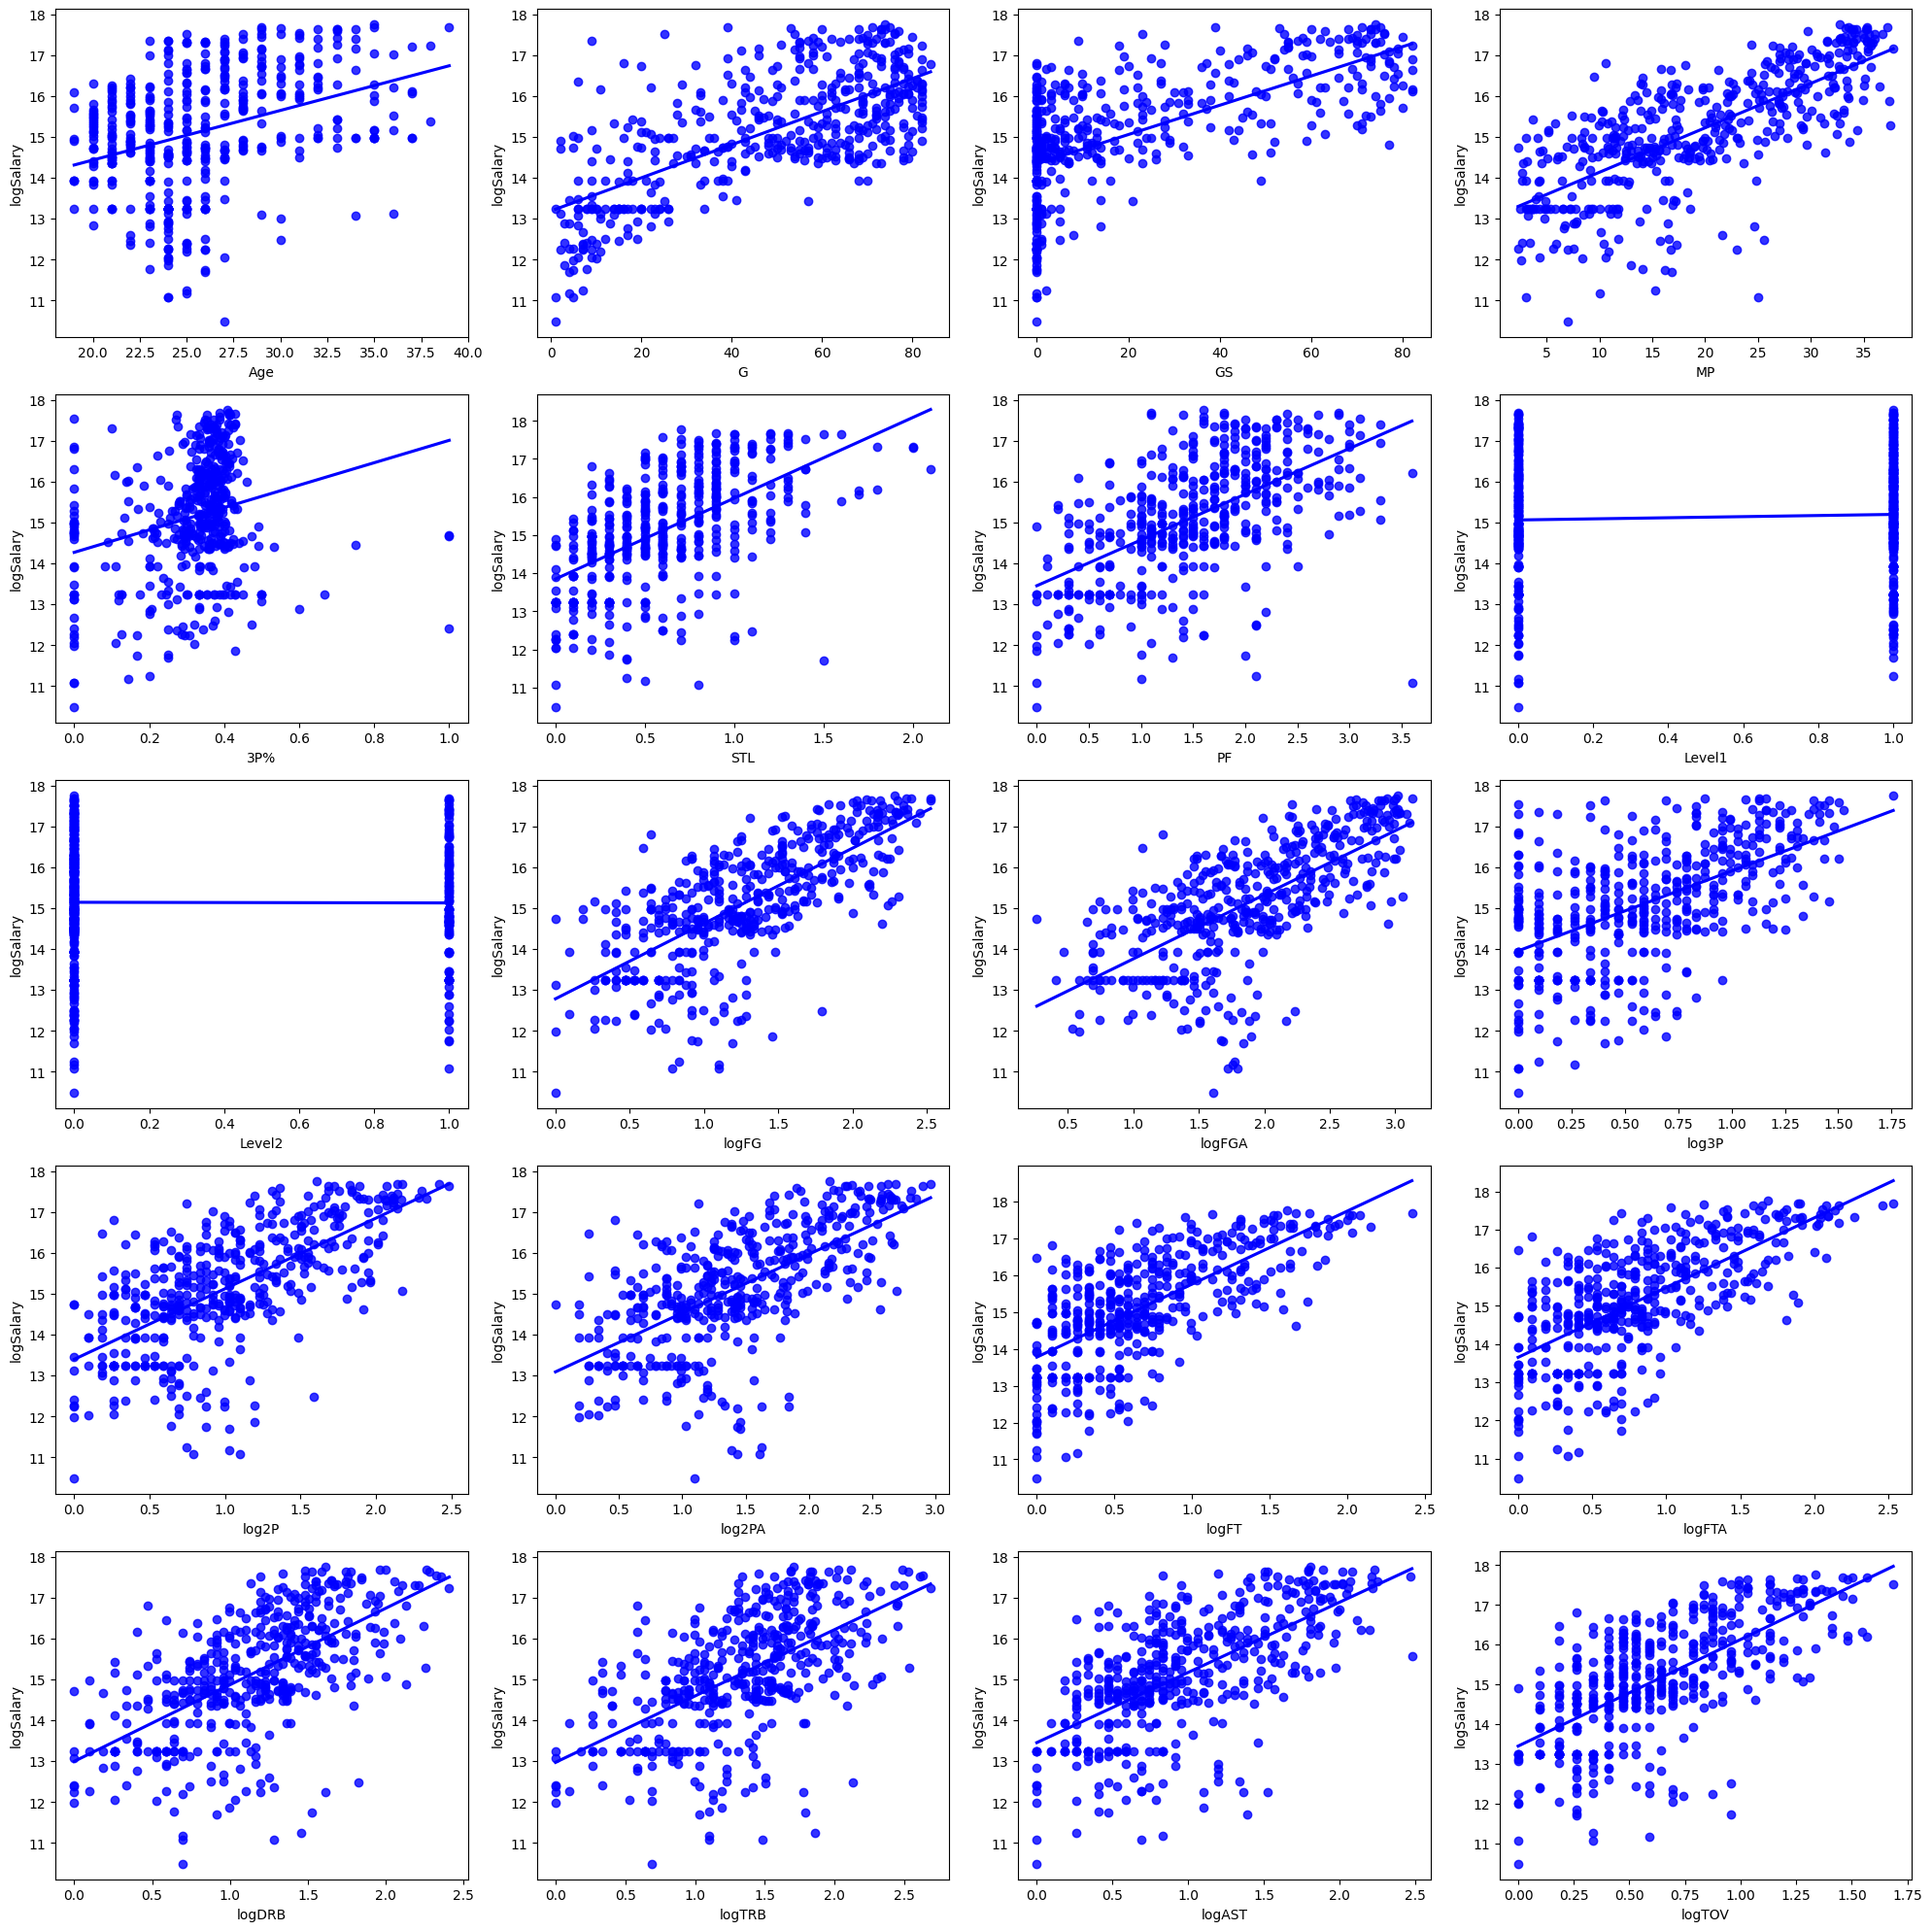

In [4]:
#散佈圖
y_var = df['logSalary'].values

feature_columns = ['Age', 'G', 'GS', 'MP', '3P%', 'STL', 'PF', 'Level1', 'Level2',
                   'logFG', 'logFGA', 'log3P', 'log2P', 'log2PA', 'logFT', 'logFTA',
                   'logDRB', 'logTRB', 'logAST', 'logTOV']

nrows = 5
ncols = 4

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

for idx, aname in enumerate(feature_columns):
    row = idx // ncols
    col = idx % ncols
    ax = axs[row, col]
    
    sns.regplot(x=df[aname].values, y=y_var, ax=ax, color='b', ci=None)
    ax.set_xlabel(aname)
    ax.set_ylabel('logSalary')

plt.tight_layout()

plt.show()

In [5]:
df = df.dropna().reset_index(drop=True)
X_data_1_ar = np.array(df[feature_columns].values).T
X_data_1_T = X_data_1_ar.T
X_data_1 = pd.DataFrame(X_data_1_T, columns=feature_columns)
X_data2 = sm.add_constant(X_data_1)
y_data_1 = df['logSalary']

In [6]:
from stepwise_regression import step_reg
forwardselect = step_reg.forward_regression(X_data2, y_data_1, 0.1, verbose=False)
print(forwardselect)

['const', 'MP', 'G', 'Age', 'logFT']


In [7]:
new_df = pd.DataFrame()

for aname in forwardselect:
    if aname != 'const' and aname != 'MP':
        if aname in df.columns:
            new_df[aname] = df[aname]
        else:
            print(f"Warning: Column {aname} not found in the original DataFrame")

Multicollinearity will not be a problem.
                            OLS Regression Results                            
Dep. Variable:              logSalary   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     303.1
Date:                Wed, 12 Jun 2024   Prob (F-statistic):          9.80e-109
Time:                        18:40:19   Log-Likelihood:                -588.38
No. Observations:                 466   AIC:                             1185.
Df Residuals:                     462   BIC:                             1201.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

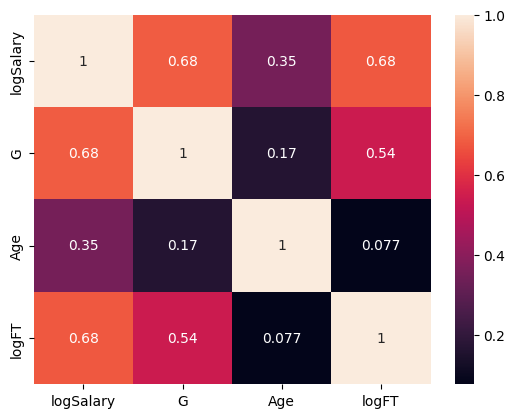

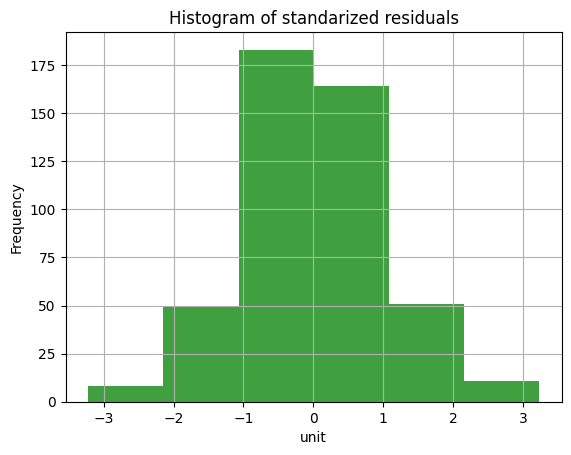

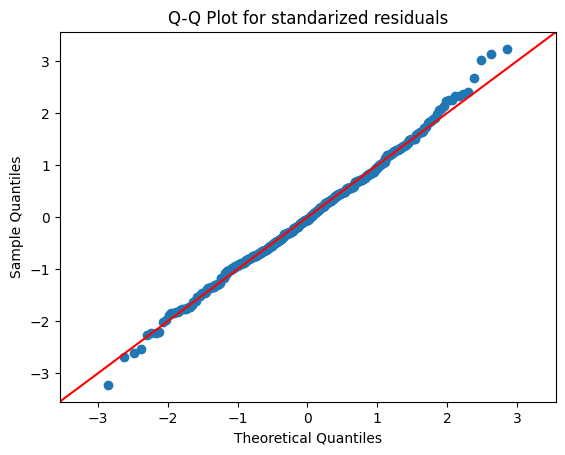


3. Homoskedasticity
H0: Homoskedasticity
H1: Heteroskedasticity


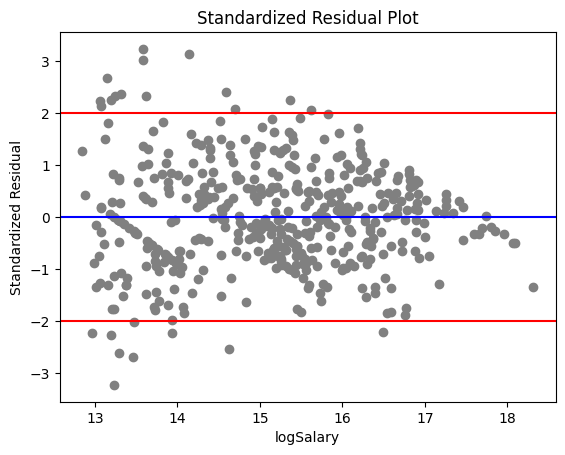

Do not rejected H0. Heteroscedasticity does not appear to be a problem.

4. Independence

4-1. Randomness
H0 : Randomness exists.
H1 : Randomness does not exist.
runs =  245
n1 =  233
n2 =  233
runs_exp =  234.0
stan_dev =  10.781904394196388
z =  1.020227929856344
pval_z =  0.30762037440778867
p_value for Z-statistic=  0.30762037440778867
Since the p_value = 0.3076 > 0.05, we do not reject the null hypothesis.
That is, we do not have sufficient evidence to claim that randomness does not exist.

4-2. No Autocorrelation
H0 : There is no first-order correlation.
H1 : There is first-order correlation.
Outliers by SD = 

0      2.666065
11    -2.270920
26     2.361122
59     2.078611
143    3.229667
148   -2.683460
150    2.329811
157    3.013761
172    2.230300
180    2.250646
270   -2.599829
276    2.323325
282   -2.231378
300   -3.220312
301    2.050078
302   -2.215451
316   -2.527482
342   -2.003306
348    2.141001
353    3.122717
377    2.255155
386    2.407018
411   -2.197549
Name: S

In [8]:
my_multiple_linear_regression(y_data_1, new_df, 0.05)